In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# View columns and type for 'measurement' table
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
print("-"*17)
print("Measurement Table")
print("-"*17)
for c in columns:
    print(c['name'], c['type'])
print('\n')   

# View columns and type for 'station' table
inspector = inspect(engine)
columns = inspector.get_columns('station')

print("-"*13)
print("Station Table")
print("-"*13)
for c in columns:
    print(c['name'], c['type'])

-----------------
Measurement Table
-----------------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


-------------
Station Table
-------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create session (link) from Python to the DB
session = Session(engine)

In [10]:
# View measurement table content
session.query(measurement.id, measurement.station, measurement.date, measurement.prcp, measurement.tobs).limit(5).all()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [11]:
# View station table content
session.query(station.id, station.station, station.name, station.latitude, station.longitude, station.elevation).all()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

# Exploratory Precipitation Analysis

In [37]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
print (f'The most recent date in the data set is {recent_date[0]}.')

The most recent date in the data set is 2017-08-23


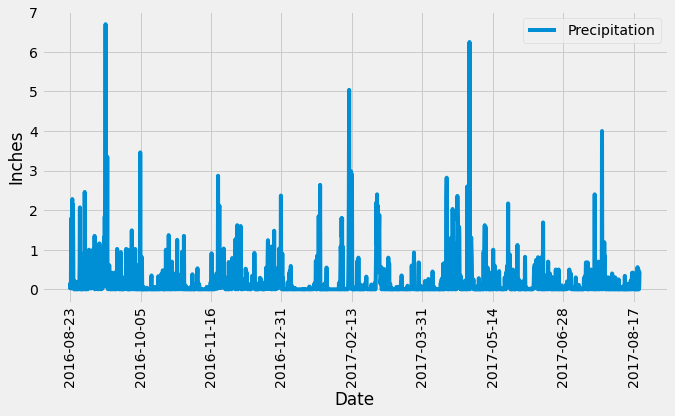

In [44]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# - Calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8 ,23) - dt.timedelta(days= 365)
query_date

# - Perform a query to retrieve the data and precipitation scores
year_data = session.query(measurement.date, measurement.prcp).filter(measurement.prcp != 'null').\
    filter(measurement.date >= (dt.date(2017, 8 ,23) - dt.timedelta(days= 365))).\
    order_by(measurement.date).all()


# - Save the query results as a Pandas DataFrame and set the index to the date column

year_df = pd.DataFrame(year_data, columns= ['Date', 'Precipitation'])
year_df.set_index("Date")

# - Sort the dataframe by date
year_df.sort_values(by='Date')

# - Use Pandas Plotting with Matplotlib to plot the data
year_df.plot('Date','Precipitation', figsize=(10,5))
plt.xticks(rotation = 'vertical')
plt.ylabel('Inches')
plt.show()


In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
year_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [40]:
# Design a query to calculate the total number stations in the dataset
total_station = session.query(station.station).distinct().count()
print(f'The total number of stations in this dataset is {total_station}')

The total number of stations in this dataset is 9


In [43]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [34]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
min_temp = session.query(func.min(measurement.tobs)).filter(measurement.station == 'USC00519281').first()
max_temp = session.query(func.max(measurement.tobs)).filter(measurement.station == 'USC00519281').first()
temp_avg = session.query(func.avg(measurement.tobs)).filter(measurement.station == 'USC00519281').first()
print(f'- The lowest temperature was {min_temp[0]}\n\
- The highest temperature was {max_temp[0]}\n\
- The average temperature was {round(temp_avg[0],2)}')

- The lowest temperature was 54.0
- The highest temperature was 85.0
- The average temperature was 71.66


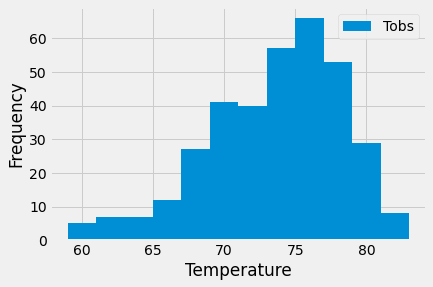

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_year = session.query(measurement.station, measurement.date, measurement.tobs).filter(measurement.station == 'USC00519281').filter(measurement.date >= (dt.date(2017, 8 ,23) - dt.timedelta(days= 365))).all()
temp_df = pd.DataFrame(temp_year, columns=['Station', 'Date', 'Tobs'])


# Plot results as histogram
temp_df.plot.hist(bins=12)
plt.xlabel("Temperature")
plt.show()

# Close session

In [19]:
# Close Session
session.close()